# Tech Challenge Fase 2 - Machine Learning and Time Series

Aluno: Matheus Silva Pereira <br>
RM: 352812 <br>
Grupo: 42

## Instalação e importação das bibliotecas

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

## Carregamento da base de dados

In [89]:

dataset = pd.read_csv('/content/Dados Históricos - Ibovespa.csv', index_col='Data', usecols = ['Data', 'Último'])
dataset.index = pd.to_datetime(dataset.index, format='%d.%m.%Y')
dataset = dataset.sort_index()

In [90]:
time_series = dataset['Último']

## Exploração da série temporal

In [91]:
time_series.index.min()

Timestamp('2014-01-02 00:00:00')

In [92]:
time_series.index.max()

Timestamp('2024-01-02 00:00:00')

In [93]:
figura = px.line(title='Histórico do índice Ibovespa')
figura.add_scatter(x = time_series.index, y = time_series)

## Decomposição da série temporal

In [94]:
decomposicao = seasonal_decompose(time_series, period=len(time_series) // 2)

In [95]:
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
residuo = decomposicao.resid

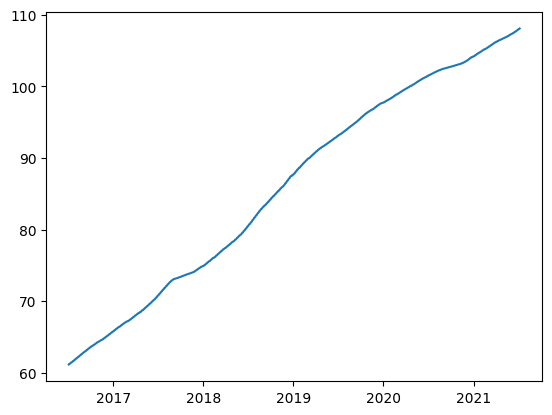

In [96]:
plt.plot(tendencia);

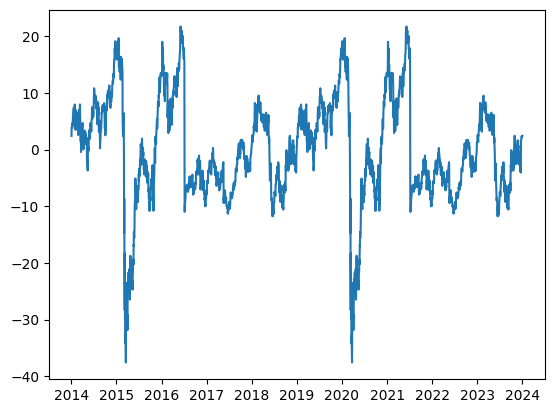

In [97]:
plt.plot(sazonal);

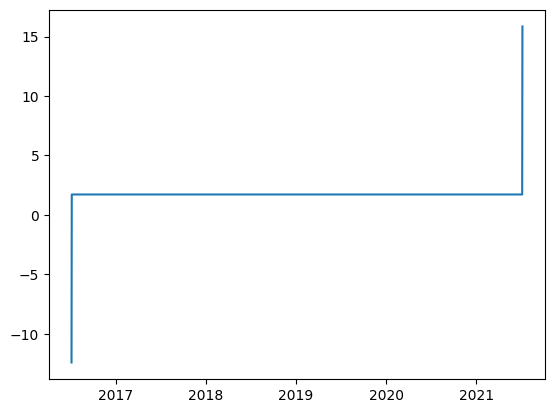

In [98]:
plt.plot(residuo);

## Separação das bases de treinamento e teste

In [99]:
len(time_series)

2477

In [100]:
treinamento = time_series['2014-01-02':'2023-09-29']

In [101]:
treinamento.index.min(), treinamento.index.max()

(Timestamp('2014-01-02 00:00:00'), Timestamp('2023-09-29 00:00:00'))

In [102]:
teste = time_series[2416:]

In [103]:
teste.index.min(), teste.index.max()

(Timestamp('2023-10-02 00:00:00'), Timestamp('2024-01-02 00:00:00'))

# Facebook Prophet

## Importação das bibliotecas

In [104]:
from prophet import Prophet
import pandas as pd

## Carregamento da base de dados

In [105]:
dataset = pd.read_csv('/content/Dados Históricos - Ibovespa.csv', usecols=['Data', 'Último'])
dataset['Data'] = pd.to_datetime(dataset['Data'], format='%d.%m.%Y')

In [106]:
dataset = dataset.rename(columns = {'Data': 'ds', 'Último': 'y'})
dataset

,ds,y
0,2024-01-02,132.697
1,2023-12-28,134.185
2,2023-12-27,134.194
3,2023-12-26,133.533
4,2023-12-22,132.753
...,...,...
2472,2014-01-08,50.577
2473,2014-01-07,50.430
2474,2014-01-06,50.974
2475,2014-01-03,50.981


## Construção do modelo e previsões

In [107]:
modelo = Prophet()
modelo.fit(dataset)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnraa2umf/w6qgsrzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnraa2umf/vjztf_ze.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28297', 'data', 'file=/tmp/tmpnraa2umf/w6qgsrzy.json', 'init=/tmp/tmpnraa2umf/vjztf_ze.json', 'output', 'file=/tmp/tmpnraa2umf/prophet_modellxxa_l_b/prophet_model-20240311221226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [108]:
futuro = modelo.make_future_dataframe(periods=61)
previsoes = modelo.predict(futuro)

## Gráfico das previsões

In [109]:
from prophet.plot import plot_plotly, plot_components_plotly

In [110]:
plot_plotly(modelo, previsoes)

In [111]:
plot_components_plotly(modelo, previsoes)

## Avaliação

In [112]:
pred = modelo.make_future_dataframe(periods=0)
previsoes = modelo.predict(pred)

In [113]:
teste.shape

(61,)

In [114]:
previsoes = previsoes['yhat'].tail(61)

In [116]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [117]:
mean_absolute_error(teste, previsoes)

6.297740294120221

In [118]:
mean_absolute_percentage_error(teste, previsoes)

0.04984473317398806

## Análisando efeito da Taxa Selic no Índice Ibovespa

### Carregamento da base de dados

In [119]:
dataset_selic = pd.read_csv('/content/taxa_selic_apurada_2014-2024.csv', sep=';', skiprows=1, usecols = ['Data', 'Taxa (% a.a.)'])
dataset_selic['Data'] = pd.to_datetime(dataset_selic['Data'], format='%d/%m/%Y')
dataset_selic['Taxa (% a.a.)'] = dataset_selic['Taxa (% a.a.)'].str.replace(',','.').astype(np.float64)
dataset_selic

,Data,Taxa (% a.a.)
0,2024-01-02,11.65
1,2023-12-29,11.65
2,2023-12-28,11.65
3,2023-12-27,11.65
4,2023-12-26,11.65
...,...,...
2504,2014-01-08,9.90
2505,2014-01-07,9.90
2506,2014-01-06,9.90
2507,2014-01-03,9.90


In [120]:
selic_time_series = dataset_selic['Taxa (% a.a.)']

In [122]:
dataset = pd.read_csv('/content/Dados Históricos - Ibovespa.csv', usecols=['Data', 'Último'])
dataset['Data'] = pd.to_datetime(dataset['Data'], format='%d.%m.%Y')

In [123]:
dataset_ibov_selic = pd.merge(dataset, dataset_selic, how='inner', on='Data')

In [124]:
dataset_ibov_selic = dataset_ibov_selic.rename(columns = {'Data': 'ds', 'Último': 'y', 'Taxa (% a.a.)': 'selic'})
dataset_ibov_selic

,ds,y,selic
0,2024-01-02,132.697,11.65
1,2023-12-28,134.185,11.65
2,2023-12-27,134.194,11.65
3,2023-12-26,133.533,11.65
4,2023-12-22,132.753,11.65
...,...,...,...
2472,2014-01-08,50.577,9.90
2473,2014-01-07,50.430,9.90
2474,2014-01-06,50.974,9.90
2475,2014-01-03,50.981,9.90


### Exploração das séries temporais

In [134]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=dataset_ibov_selic['ds'], y=dataset_ibov_selic['y'], name="Ibovespa"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=dataset_ibov_selic['ds'], y=dataset_ibov_selic['selic'], name="Selic"),
    secondary_y=True,
)

fig.update_layout(
    title_text="Ibovespa x Selic: 2014-2024"
)

fig.update_yaxes(title_text="<b>Índice</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Taxa</b>", secondary_y=True)

fig.show()

### Divisão das bases de treinamento e teste

In [125]:
data_train = dataset_ibov_selic.iloc[61:].copy()
data_test = dataset_ibov_selic.copy

### Construção do modelo e previsões

In [126]:
modelo = Prophet()
modelo.add_regressor('selic')
modelo.fit(data_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnraa2umf/zg0ps06d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnraa2umf/lzto9kfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69136', 'data', 'file=/tmp/tmpnraa2umf/zg0ps06d.json', 'init=/tmp/tmpnraa2umf/lzto9kfd.json', 'output', 'file=/tmp/tmpnraa2umf/prophet_modelrqlx7law/prophet_model-20240311221229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [127]:
previsoes = modelo.predict(data_test)

### Gráfico das previsões

In [128]:
plot_plotly(modelo, previsoes)

### Avaliação

In [129]:
previsoes = previsoes['yhat'].tail(61)

In [130]:
mean_absolute_error(teste, previsoes)

6.6970964408447164

In [131]:
mean_absolute_percentage_error(teste, previsoes)

0.05293285097595634